In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

- In the given dataset, "styles.csv," some errors occurred while reading the file using pandas.
- To address this, we generated a dataset in CSV format using the images and styles directories.
- Additionally, some images were missing from the images directory.
- Therefore, we mapped the styles directory with the images directory to ensure proper alignment.

In [2]:
import os
import json
from tqdm import tqdm

IMAGE_DIR = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/"
STYLE_DIR = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles/"

In [ ]:
def load_json_sequential():
    json_files = [os.path.join(STYLE_DIR, f) for f in os.listdir(STYLE_DIR) if f.endswith('.json')]
    metadata = []
    
    def get_value(data, key, default=pd.NA):  
        """ Helper function to handle missing values correctly. """
        value = data.get(key)
        return value if value not in [None, "", "null", "NaN", "NA"] else default
    
    for file_path in tqdm(json_files, desc="Processing JSONs"):
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f).get("data", {})
            
            metadata.append({
                "id": data.get("id"),  # Keep as original type (int/str)
                "productDisplayName": get_value(data, "productDisplayName"),
                "brandName": get_value(data, "brandName"),
                "gender": get_value(data, "gender"),
                "baseColour": get_value(data, "baseColour"),
                "season": get_value(data, "season"),
                "year": get_value(data, "year"),
                "usage": get_value(data, "usage"),
                "masterCategory": get_value(data.get("masterCategory", {}), "typeName"),
                "subCategory": get_value(data.get("subCategory", {}), "typeName"),
                "articleType": get_value(data.get("articleType", {}), "typeName"),
                "imageURL": get_value(data.get("styleImages", {}).get("default", {}), "imageURL"),
            })
        except (json.JSONDecodeError, OSError) as e:
            print(f"Error processing {file_path}: {e}")
    
    return pd.DataFrame(metadata)


In [4]:
df = load_json_sequential()

Processing JSONs: 100%|██████████| 44446/44446 [00:39<00:00, 1135.84it/s]


In [9]:
print(df.shape)
df.head()

(44446, 12)


,id,productDisplayName,brandName,gender,baseColour,season,year,usage,masterCategory,subCategory,articleType,imageURL
0,1566,Artengo Men Black Cap,Artengo,Men,Black,Summer,2011,Sports,Accessories,Headwear,Caps,http://assets.myntassets.com/v1/images/style/p...
1,39342,Fila Men Zoom Black Shoes,FILA,Men,Black,Summer,2012,Casual,Footwear,Shoes,Casual Shoes,http://assets.myntassets.com/v1/images/style/p...
2,13182,FILA Men Dls Maxim Black Sports Shoes,FILA,Men,Black,Fall,2011,Sports,Footwear,Shoes,Sports Shoes,http://assets.myntassets.com/v1/images/style/p...
3,21762,Fossil Men Mead Black Belt,Fossil,Men,Black,Fall,2011,Casual,Accessories,Belts,Belts,http://assets.myntassets.com/v1/images/style/p...
4,48692,Lucera Women Silver Earrings,Lucera,Women,Silver,Summer,2012,Casual,Accessories,Jewellery,Earrings,http://assets.myntassets.com/v1/images/style/p...


In [10]:
df.isnull().sum()

id                      0
productDisplayName      7
brandName               0
gender                  0
baseColour             15
season                 21
year                    1
usage                 317
masterCategory          0
subCategory             0
articleType             0
imageURL                5
dtype: int64

In [16]:
# Handle missing values
df.fillna({
    "baseColour": "Unknown",
    "season": "Unknown",
    "gender": "Unisex",
    "usage": "Unknown",
}, inplace=True)


df["year"] = pd.to_numeric(df["year"], errors="coerce")
df["year"] = df["year"].fillna(df["year"].median()).astype(int)

# Fill missing "productDisplayName" using brandName + articleType
df["productDisplayName"] = df.apply(
    lambda row: f"{row['brandName']} {row['articleType']}" if pd.isna(row["productDisplayName"]) else row["productDisplayName"],
    axis=1
)


In [21]:
print(f"Total Images : {len(os.listdir(IMAGE_DIR))}")
print(f"Total Style Json : {len(os.listdir(STYLE_DIR))}")

Total Images : 44441
Total Style Json : 44446


- So, filter missing images

In [22]:
# Filter missing images and only available images are used
df["image_path"] = df["id"].astype(str) + ".jpg"
df = df[df["image_path"].map(lambda x: os.path.exists(os.path.join(IMAGE_DIR, x)))]

In [23]:
print(df.shape)
df.head()

(44441, 13)


,id,productDisplayName,brandName,gender,baseColour,season,year,usage,masterCategory,subCategory,articleType,imageURL,image_path
0,1566,Artengo Men Black Cap,Artengo,Men,Black,Summer,2011,Sports,Accessories,Headwear,Caps,http://assets.myntassets.com/v1/images/style/p...,1566.jpg
1,39342,Fila Men Zoom Black Shoes,FILA,Men,Black,Summer,2012,Casual,Footwear,Shoes,Casual Shoes,http://assets.myntassets.com/v1/images/style/p...,39342.jpg
2,13182,FILA Men Dls Maxim Black Sports Shoes,FILA,Men,Black,Fall,2011,Sports,Footwear,Shoes,Sports Shoes,http://assets.myntassets.com/v1/images/style/p...,13182.jpg
3,21762,Fossil Men Mead Black Belt,Fossil,Men,Black,Fall,2011,Casual,Accessories,Belts,Belts,http://assets.myntassets.com/v1/images/style/p...,21762.jpg
4,48692,Lucera Women Silver Earrings,Lucera,Women,Silver,Summer,2012,Casual,Accessories,Jewellery,Earrings,http://assets.myntassets.com/v1/images/style/p...,48692.jpg


In [24]:
print(f"Dataset shape: {df.shape}\n")
df.info()
df.describe()

Dataset shape: (44441, 13)

<class 'pandas.core.frame.DataFrame'>
Index: 44441 entries, 0 to 44445
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  44441 non-null  int64 
 1   productDisplayName  44441 non-null  object
 2   brandName           44441 non-null  object
 3   gender              44441 non-null  object
 4   baseColour          44441 non-null  object
 5   season              44441 non-null  object
 6   year                44441 non-null  int64 
 7   usage               44441 non-null  object
 8   masterCategory      44441 non-null  object
 9   subCategory         44441 non-null  object
 10  articleType         44441 non-null  object
 11  imageURL            44441 non-null  object
 12  image_path          44441 non-null  object
dtypes: int64(2), object(11)
memory usage: 4.7+ MB


,id,year
count,44441.000000,44441.000000
mean,29692.147049,2012.805855
std,17048.746205,2.126390
min,1163.000000,2007.000000
25%,14770.000000,2011.000000
50%,28608.000000,2012.000000
75%,44680.000000,2015.000000
max,60000.000000,2019.000000


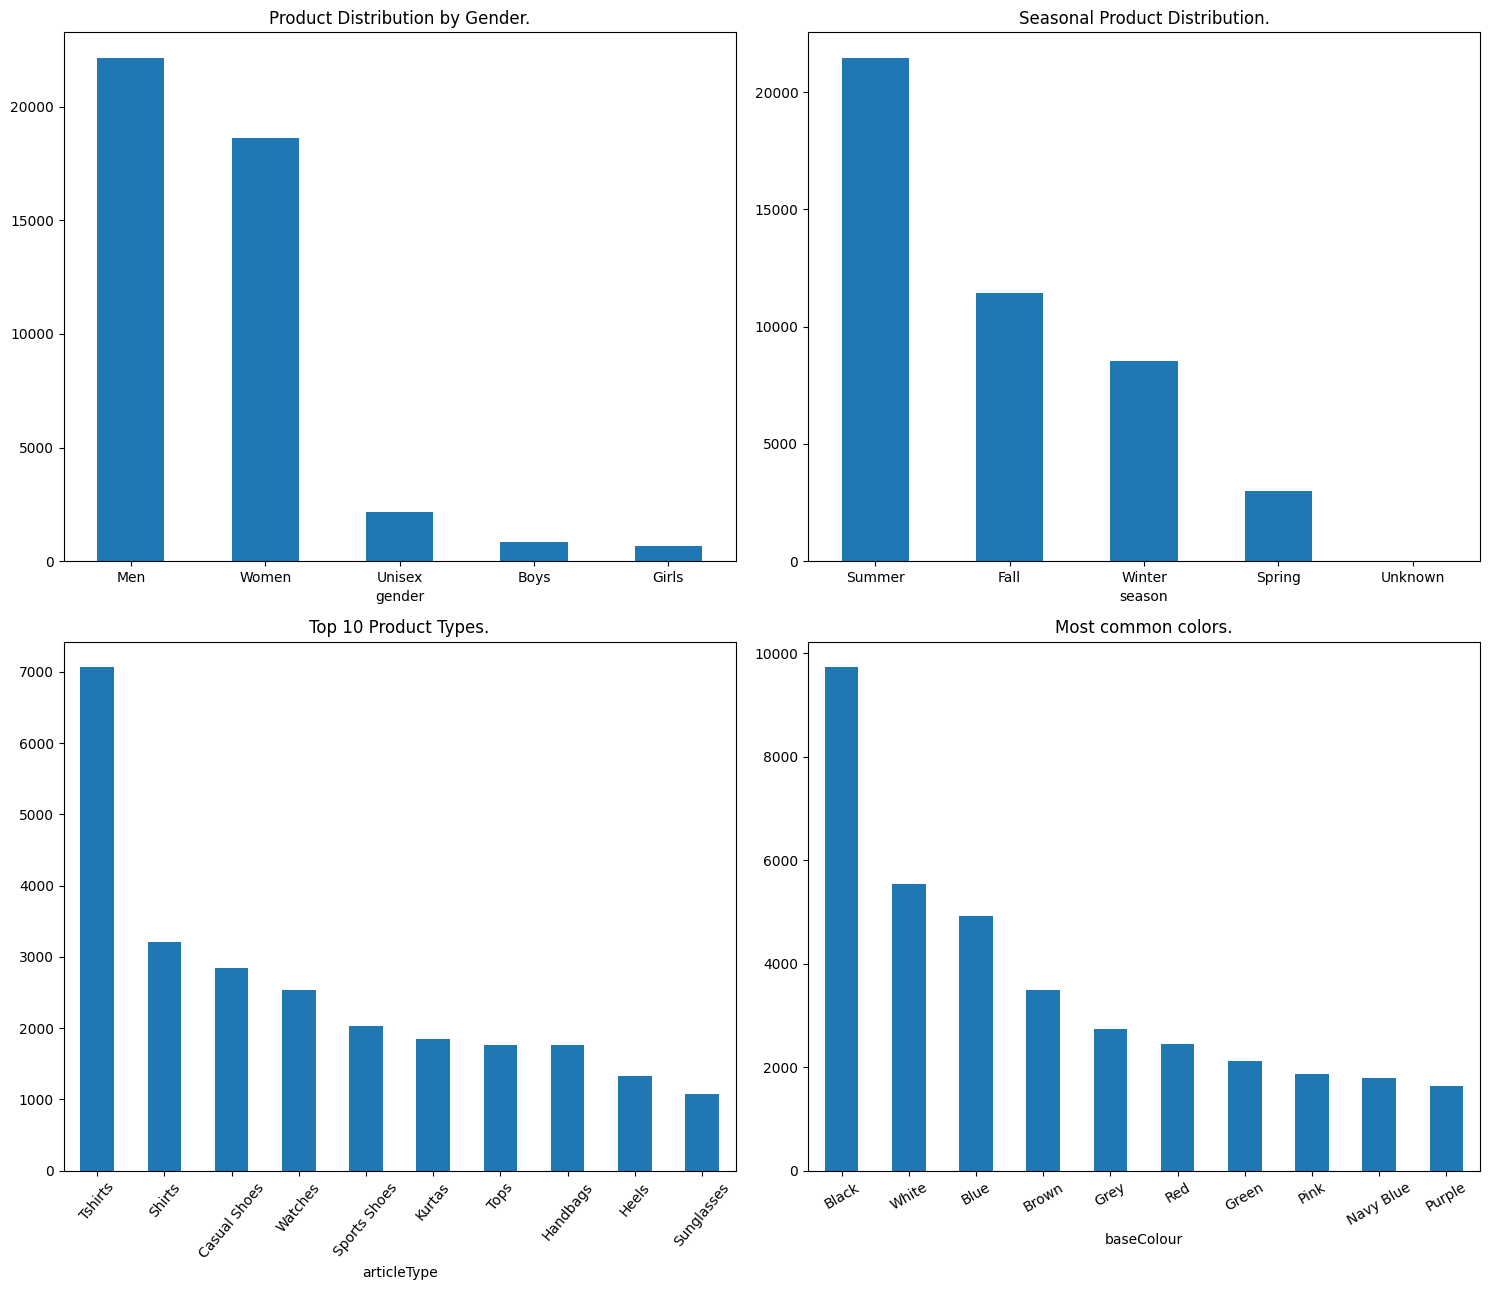

In [25]:
plt.figure(figsize = (15, 13))

plt.subplot(2, 2, 1)
df['gender'].value_counts().plot(kind='bar')
plt.title("Product Distribution by Gender.")
plt.xticks(rotation=0)

plt.subplot(2, 2, 2)
df['season'].value_counts().plot(kind='bar')
plt.title("Seasonal Product Distribution.")
plt.xticks(rotation=0)

plt.subplot(2, 2, 3)
df['articleType'].value_counts().head(10).plot(kind='bar')
plt.title("Top 10 Product Types.")
plt.xticks(rotation=50)

plt.subplot(2, 2, 4)
df['baseColour'].value_counts().head(10).plot(kind='bar')
plt.title("Most common colors.")
plt.xticks(rotation=30)

plt.tight_layout()
plt.show()

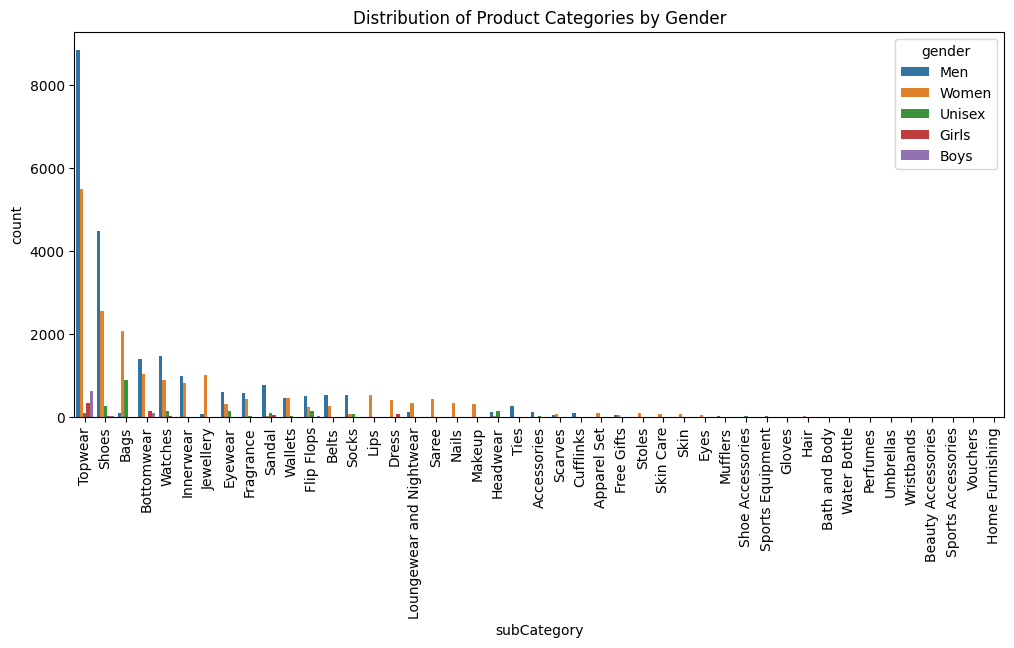

In [26]:
# Gender vs. Product Category
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='subCategory', hue='gender', order=df['subCategory'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Distribution of Product Categories by Gender")
plt.show()

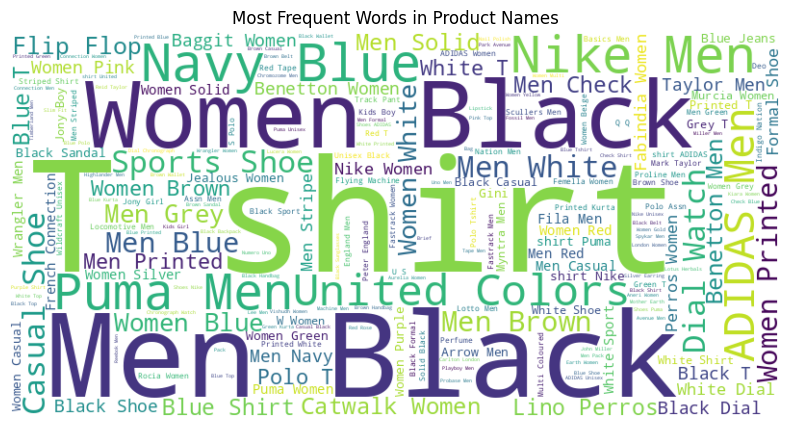

In [27]:
from wordcloud import WordCloud

text = " ".join(df['productDisplayName'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Product Names")
plt.show()

In [28]:
df.to_csv("Cleaned_Data.csv", index=False)

- Sample Images

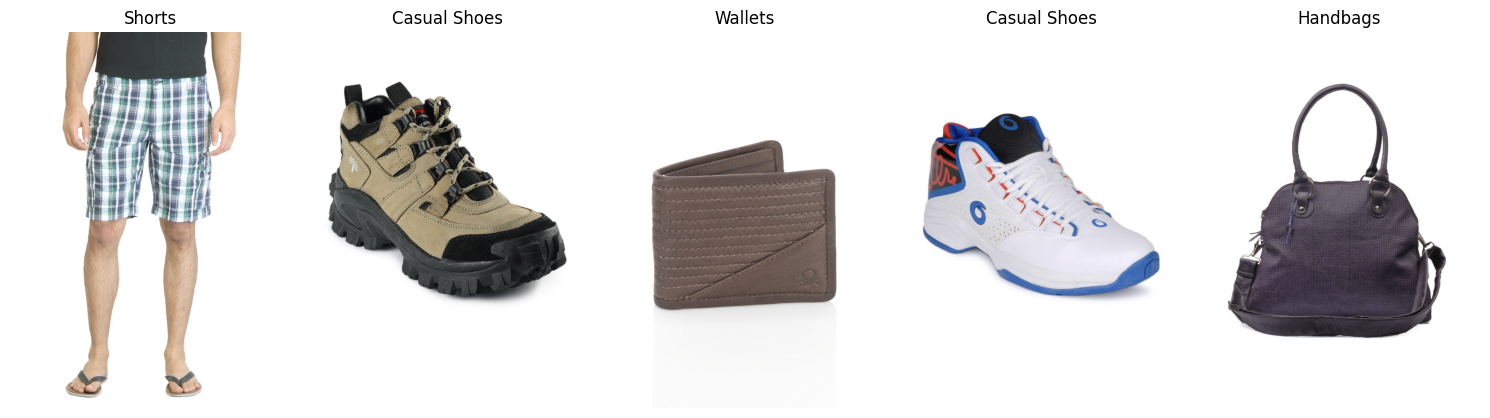

In [32]:
from PIL import Image

sample_df = df.sample(5)
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, row in enumerate(sample_df.itertuples()):
    img_path = f"{IMAGE_DIR}/{row.id}.jpg"
    img = Image.open(img_path)
    img_array = np.array(img)
    
    # Display the image
    axes[i].imshow(img_array)
    axes[i].axis('off')
    axes[i].set_title(row.articleType, fontsize=12, wrap=True)

plt.tight_layout()
plt.show()